In [1]:
import sys
sys.path.insert(0, '../')

import os
import torch
from functions import CustomSampler, load_pretrained_mlp, load_pretrained_cae, get_model_predictions, average_fusion_predictions, calculate_classification_report, calculate_fusion_accuracy
from ae_functions import get_latent_dataloader
from ae_models import improvedCAE, simpleCAE
from mlp_functions import train_mlp, validate_mlp, decision_level_fusion
from mlp_models import improvedMLP, simpleMLP
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

In [2]:
def get_predictions(pred):
    batch_pred = []
    for batch in pred:
        batch_pred.extend(batch.argmax(dim=-1).cpu().numpy())
    return batch_pred

def unpack_labels(labels):
    batch_labels = []
    for batch in labels:
        batch_labels.extend(batch)
    return batch_labels

In [3]:
def get_confusion_matrix(preds_list, class_names, true_labels, setup, save_dir):
    sensor = ["Color", "Icub_left", "Icub_right", "Depth"]
    for s, preds in enumerate(preds_list):
        matrix = confusion_matrix(true_labels, preds)

        plt.figure(figsize=(10, 8))  # Adjust figure size for better readability
        plt.imshow(matrix, cmap='Blues')

        # Add explicit values to the confusion matrix
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                color = 'white' if matrix[i, j] > matrix.max() / 2 else 'black'  # Contrast color for readability
                plt.text(j, i, format(matrix[i, j], 'd'), ha='center', va='center', 
                        color=color, fontsize=14, weight='bold')  # Adjust font size and add background

        plt.colorbar()
        plt.xticks(range(len(class_names)), class_names, fontsize=12)  # Rotate x-axis labels for better visibility
        plt.yticks(range(len(class_names)), class_names, fontsize=12)
        plt.xlabel('Predicted', fontsize=12)  # Increase font size
        plt.ylabel('True', fontsize=12)  # Increase font size
        plt.title(f'Confusion Matrix {setup} For {sensor[s]} Sensor', fontsize=16)  # Increase font size

        # Move x-axis to the top
        ax = plt.gca()
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')

        # Adjust layout
        plt.tight_layout()

        # Save the confusion matrix
        save_path = os.path.join(save_dir, f'confusion_matrix_{setup}_{sensor[s]}.png')
        plt.savefig(save_path)
        plt.close()
        print(f"Saved confusion matrix for {sensor[s]} sensor")

In [10]:
def get_confusion_matrix_fusion(preds, class_names, true_labels, setup, save_dir):
    matrix = confusion_matrix(true_labels, preds)

    plt.figure(figsize=(10, 8))  # Adjust figure size for better readability
    plt.imshow(matrix, cmap='Blues')

                                        # Add explicit values to the confusion matrix
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            color = 'white' if matrix[i, j] > matrix.max() / 2 else 'black'  # Contrast color for readability
            plt.text(j, i, format(matrix[i, j], 'd'), ha='center', va='center', color=color, fontsize=14, weight='bold')  # Adjust font size and add background

    plt.colorbar()
    plt.xticks(range(len(class_names)), class_names, fontsize=12)  # Rotate x-axis labels for better visibility
    plt.yticks(range(len(class_names)), class_names, fontsize=12)
    plt.xlabel('Predicted', fontsize=12)  # Increase font size
    plt.ylabel('True', fontsize=12)  # Increase font size
    plt.title(f'Confusion Matrix {setup}', fontsize=16)  # Increase font size

    # Move x-axis to the top
    ax = plt.gca()
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    # Adjust layout
    plt.tight_layout()

    # Save the confusion matrix
    save_path = os.path.join(save_dir, f'confusion_matrix_{setup}.png')
    plt.savefig(save_path)
    plt.close()
    print(f"Saved confusion matrix for {setup}")

In [5]:
def get_accuracy(preds_list, true_labels):
    accuracies = []
    for preds in preds_list:
        accuracies.append(accuracy_score(true_labels, preds))
    print("color: ", accuracies[0], " left: ", accuracies[1], " right: ", accuracies[2])

In [6]:
BATCH_SIZE = 8

DEVICE = ""
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("CUDA is available. Using GPU...")
else:
    DEVICE = torch.device("cpu")
    print("CUDA is not available. Using CPU...")

# Define the tool names and actions
TOOL_NAMES = ['hook', 'ruler', 'spatula', 'sshot']
ACTIONS = ['left_to_right', 'pull', 'push', 'right_to_left']

# All available object names
OBJECTS = ['0_woodenCube', '1_pearToy', '2_yogurtYellowbottle', '3_cowToy', '4_tennisBallYellowGreen',
            '5_blackCoinbag', '6_lemonSodaCan', '7_peperoneGreenToy', '8_boxEgg','9_pumpkinToy',
            '10_tomatoCan', '11_boxMilk', '12_containerNuts', '13_cornCob', '14_yellowFruitToy',
            '15_bottleNailPolisher', '16_boxRealSense', '17_clampOrange', '18_greenRectangleToy', '19_ketchupToy']

BASE_PATH = 'C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/fusion'

sensor_color = "color"
sensor_left = "icub_left"
sensor_right = "icub_right"
sensor_depth = "depthcolormap"  

CUDA is available. Using GPU...


In [7]:
# # Load CAE models
model_path = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/weights_ae/"
simple_cae_color = load_pretrained_cae(simpleCAE, model_path, "simple/simple_cae_ne3_b8_color.pth", DEVICE)
simple_cae_left = load_pretrained_cae(simpleCAE, model_path, "simple/simple_cae_ne3_b8_icub_left.pth", DEVICE)
simple_cae_right = load_pretrained_cae(simpleCAE, model_path, "simple/simple_cae_ne3_b8_icub_right.pth", DEVICE)
simple_cae_depth = load_pretrained_cae(simpleCAE, model_path, "simple/simple_cae_ne3_b8_depthcolormap.pth", DEVICE)

# Load CAE models Improved
improved_dcae_color = load_pretrained_cae(improvedCAE, model_path, "improved/improved_cae_ne3_b8_color_noise.pth", DEVICE)
improved_dcae_left = load_pretrained_cae(improvedCAE, model_path, "improved/improved_cae_ne3_b8_icub_left_noise.pth", DEVICE)
improved_dcae_right = load_pretrained_cae(improvedCAE, model_path, "improved/improved_cae_ne3_b8_icub_right_noise.pth", DEVICE)

# Load CAE models Improved
improved_cae_color = load_pretrained_cae(improvedCAE, model_path, "improved/improved_cae_ne3_b8_color.pth", DEVICE)
improved_cae_left = load_pretrained_cae(improvedCAE, model_path, "improved/improved_cae_ne3_b8_icub_left.pth", DEVICE)
improved_cae_right = load_pretrained_cae(improvedCAE, model_path, "improved/improved_cae_ne3_b8_icub_right.pth", DEVICE)
improved_cae_depth = load_pretrained_cae(improvedCAE, model_path, "improved/improved_cae_ne3_b8_depthcolormap.pth", DEVICE)

In [8]:
# # Load MLP models
# simple_mlp_improved_cae_color_tool = load_pretrained_mlp(simpleMLP, model_path, "simple/simple_mlp_improved_cae_ne3_b8_color_tool.pth", DEVICE, input_dim, output_dim)
# simple_mlp_improved_cae_left_tool = load_pretrained_mlp(simpleMLP, model_path, "simple/simple_mlp_improved_cae_ne3_b8_icub_left_tool.pth", DEVICE, input_dim, output_dim)
# simple_mlp_improved_cae_right_tool = load_pretrained_mlp(simpleMLP, model_path, "simple/simple_mlp_improved_cae_ne3_b8_icub_right_tool.pth", DEVICE, input_dim, output_dim)

In [11]:
# simpleCAE + simpleMLP

# Assuming the datasets for all sensors are the same size
dataset_size = 640  # Replace with the actual size of your dataset
shuffled_indices = torch.randperm(dataset_size).tolist()

# Get dataloaders
set_name = "Testing"
test_loader_color, size = get_latent_dataloader(simple_cae_color, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_color, set_name, labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)
test_loader_left, size = get_latent_dataloader(simple_cae_left, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_left, set_name, labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)
test_loader_right, size = get_latent_dataloader(simple_cae_right, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_right, set_name, labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)
test_loader_depth, size = get_latent_dataloader(simple_cae_depth, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_depth, set_name,labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)

dataloaders = [test_loader_color, test_loader_left, test_loader_right, test_loader_depth]

##### CONFIG
output_dim = 4
input_dim = size

model_path = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/weights_mlp/"
simple_mlp_color = load_pretrained_mlp(simpleMLP, model_path, "simple/simple_mlp_ne3_b8_color_action.pth", DEVICE, input_dim, output_dim)
simple_mlp_left = load_pretrained_mlp(simpleMLP, model_path, "simple/simple_mlp_ne3_b8_icub_left_action.pth", DEVICE, input_dim, output_dim)
simple_mlp_right = load_pretrained_mlp(simpleMLP, model_path, "simple/simple_mlp_ne3_b8_icub_right_action.pth", DEVICE, input_dim, output_dim)
simple_mlp_depth = load_pretrained_mlp(simpleMLP, model_path, "simple/simple_mlp_ne3_b8_depthcolormap_action.pth", DEVICE, input_dim, output_dim)

models = [simple_mlp_color, simple_mlp_left, simple_mlp_right, simple_mlp_depth]

model_predictions = [get_model_predictions(model, dataloader, DEVICE) for model, dataloader in zip(models, dataloaders)] 

color = model_predictions[0]
left = model_predictions[1]
right = model_predictions[2]
depth = model_predictions[3]

# Gather true labels and calculate accuracy
class_names = ['left_to_right', 'pull', 'push', 'right_to_left']
#class_names = ['hook', 'ruler', 'spatula', 'sshot']
true_labels = [labels.cpu().numpy() for _, labels in test_loader_color]
true_labels = unpack_labels(true_labels)

# color_preds = get_predictions(color)
# left_preds = get_predictions(left)
# right_preds = get_predictions(right)
# depth_preds = get_predictions(depth)  

# dir = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/models/runs/results/matrixes/correct/"
# get_confusion_matrix([color_preds, left_preds, right_preds, depth_preds], class_names, true_labels, "simpleCAE+simpleMLP", dir)

final_predictions = average_fusion_predictions(model_predictions)

# Convert to predicted classes
predicted_classes = [pred.argmax(dim=-1) for pred in final_predictions]
predicted_classes_list = [pred.cpu().numpy() if torch.is_tensor(pred) else pred for pred in predicted_classes]

dir = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/models/runs/results/matrixes/correct/"
pr = get_predictions(final_predictions)
get_confusion_matrix_fusion(pr, class_names, true_labels,"simpleCAE+simpleMLP+Fusion", dir)

Saved confusion matrix for simpleCAE+simpleMLP+Fusion


In [12]:
# Assuming the datasets for all sensors are the same size
dataset_size = 640  # Replace with the actual size of your dataset
shuffled_indices = torch.randperm(dataset_size).tolist()

# Get dataloaders
set_name = "Testing"
test_loader_color, size = get_latent_dataloader(simple_cae_color, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_color, set_name, labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)
test_loader_left, size = get_latent_dataloader(simple_cae_left, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_left, set_name, labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)
test_loader_right, size = get_latent_dataloader(simple_cae_right, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_right, set_name, labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)
test_loader_depth, size = get_latent_dataloader(simple_cae_depth, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_depth, set_name,labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)

dataloaders = [test_loader_color, test_loader_left, test_loader_right, test_loader_depth]

##### CONFIG
output_dim = 4
input_dim = size

model_path = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/weights_mlp/"
improved_mlp_simple_color = load_pretrained_mlp(improvedMLP, model_path, "simple/improved_mlp_simple_cae_ne3_b8_color.pth", DEVICE, input_dim, output_dim)
improved_mlp_simple_left = load_pretrained_mlp(improvedMLP, model_path, "simple/improved_mlp_simple_cae_ne3_b8_icub_left.pth", DEVICE, input_dim, output_dim)
improved_mlp_simple_right = load_pretrained_mlp(improvedMLP, model_path, "simple/improved_mlp_simple_cae_ne3_b8_icub_right.pth", DEVICE, input_dim, output_dim)
improved_mlp_simple_depth = load_pretrained_mlp(improvedMLP, model_path, "simple/improved_mlp_simple_cae_ne3_b8_depthcolormap.pth", DEVICE, input_dim, output_dim)

models = [improved_mlp_simple_color, improved_mlp_simple_left, improved_mlp_simple_right, improved_mlp_simple_depth]

model_predictions = [get_model_predictions(model, dataloader, DEVICE) for model, dataloader in zip(models, dataloaders)] 

color = model_predictions[0]
left = model_predictions[1]
right = model_predictions[2]
depth = model_predictions[3]

# Gather true labels and calculate accuracy
class_names = ['left_to_right', 'pull', 'push', 'right_to_left']
#class_names = ['hook', 'ruler', 'spatula', 'sshot']
true_labels = [labels.cpu().numpy() for _, labels in test_loader_color]
true_labels = unpack_labels(true_labels)

# color_preds = get_predictions(color)
# left_preds = get_predictions(left)
# right_preds = get_predictions(right)
# depth_preds = get_predictions(depth)  

# dir = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/models/runs/results/matrixes/correct/"
# get_confusion_matrix([color_preds, left_preds, right_preds, depth_preds], class_names, true_labels, "simpleCAE+improvedMLP", dir)


final_predictions = average_fusion_predictions(model_predictions)

# Convert to predicted classes
predicted_classes = [pred.argmax(dim=-1) for pred in final_predictions]
predicted_classes_list = [pred.cpu().numpy() if torch.is_tensor(pred) else pred for pred in predicted_classes]

dir = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/models/runs/results/matrixes/correct/"
pr = get_predictions(final_predictions)
get_confusion_matrix_fusion(pr, class_names, true_labels,"simpleCAE+improvedMLP+Fusion", dir)

Saved confusion matrix for simpleCAE+improvedMLP+Fusion


In [13]:
# Assuming the datasets for all sensors are the same size
dataset_size = 640  # Replace with the actual size of your dataset
shuffled_indices = torch.randperm(dataset_size).tolist()

# Get dataloaders
set_name = "Testing"
test_loader_color, size = get_latent_dataloader(improved_cae_color, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_color, set_name, labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)
test_loader_left, size = get_latent_dataloader(improved_cae_left, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_left, set_name, labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)
test_loader_right, size = get_latent_dataloader(improved_cae_right, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_right, set_name, labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)
test_loader_depth, size = get_latent_dataloader(improved_cae_depth, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_depth, set_name,labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)

dataloaders = [test_loader_color, test_loader_left, test_loader_right, test_loader_depth]

##### CONFIG
output_dim = 4
input_dim = size

simple_mlp_improved_cae_color = load_pretrained_mlp(simpleMLP, model_path, "simple/simple_mlp_improved_cae_ne3_b8_color_action.pth", DEVICE, input_dim, output_dim)
simple_mlp_improved_cae_left = load_pretrained_mlp(simpleMLP, model_path, "simple/simple_mlp_improved_cae_ne3_b8_icub_left_action.pth", DEVICE, input_dim, output_dim)
simple_mlp_improved_cae_right = load_pretrained_mlp(simpleMLP, model_path, "simple/simple_mlp_improved_cae_ne3_b8_icub_right_action.pth", DEVICE, input_dim, output_dim)
simple_mlp_improved_cae_depth = load_pretrained_mlp(simpleMLP, model_path, "simple/simple_mlp_improved_cae_ne3_b8_depthcolormap_action.pth", DEVICE, input_dim, output_dim)

models = [simple_mlp_improved_cae_color, simple_mlp_improved_cae_left, simple_mlp_improved_cae_right, simple_mlp_improved_cae_depth]

model_predictions = [get_model_predictions(model, dataloader, DEVICE) for model, dataloader in zip(models, dataloaders)] 

color = model_predictions[0]
left = model_predictions[1]
right = model_predictions[2]
depth = model_predictions[3]

# Gather true labels and calculate accuracy
class_names = ['left_to_right', 'pull', 'push', 'right_to_left']
#class_names = ['hook', 'ruler', 'spatula', 'sshot']
true_labels = [labels.cpu().numpy() for _, labels in test_loader_color]
true_labels = unpack_labels(true_labels)

# color_preds = get_predictions(color)
# left_preds = get_predictions(left)
# right_preds = get_predictions(right)
# depth_preds = get_predictions(depth)  

# dir = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/models/runs/results/matrixes/correct/"
# get_confusion_matrix([color_preds, left_preds, right_preds, depth_preds], class_names, true_labels, "improvedCAE+simpleMLP", dir)


final_predictions = average_fusion_predictions(model_predictions)

# Convert to predicted classes
predicted_classes = [pred.argmax(dim=-1) for pred in final_predictions]
predicted_classes_list = [pred.cpu().numpy() if torch.is_tensor(pred) else pred for pred in predicted_classes]

dir = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/models/runs/results/matrixes/correct/"
pr = get_predictions(final_predictions)
get_confusion_matrix_fusion(pr, class_names, true_labels,"improvedCAE+simpleMLP+Fusion", dir)

Saved confusion matrix for improvedCAE+simpleMLP+Fusion


In [14]:
# Assuming the datasets for all sensors are the same size
dataset_size = 640  # Replace with the actual size of your dataset
shuffled_indices = torch.randperm(dataset_size).tolist()

# Get dataloaders
set_name = "Testing"
test_loader_color, size = get_latent_dataloader(improved_cae_color, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_color, set_name, labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)
test_loader_left, size = get_latent_dataloader(improved_cae_left, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_left, set_name, labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)
test_loader_right, size = get_latent_dataloader(improved_cae_right, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_right, set_name, labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)
test_loader_depth, size = get_latent_dataloader(improved_cae_depth, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_depth, set_name,labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)

dataloaders = [test_loader_color, test_loader_left, test_loader_right, test_loader_depth]

##### CONFIG
output_dim = 4
input_dim = size

improved_mlp_improved_cae_color = load_pretrained_mlp(improvedMLP, model_path, "simple/improved_mlp_improved_cae_ne3_b8_color_action.pth", DEVICE, input_dim, output_dim)
improved_mlp_improved_cae_left = load_pretrained_mlp(improvedMLP, model_path, "simple/improved_mlp_improved_cae_ne3_b8_icub_left_action.pth", DEVICE, input_dim, output_dim)
improved_mlp_improved_cae_right = load_pretrained_mlp(improvedMLP, model_path, "simple/improved_mlp_improved_cae_ne3_b8_icub_right_action.pth", DEVICE, input_dim, output_dim)
improved_mlp_improved_cae_depth = load_pretrained_mlp(improvedMLP, model_path, "simple/improved_mlp_improved_cae_ne3_b8_depthcolormap_action.pth", DEVICE, input_dim, output_dim)

models = [improved_mlp_improved_cae_color, improved_mlp_improved_cae_left, improved_mlp_improved_cae_right, improved_mlp_improved_cae_depth]

model_predictions = [get_model_predictions(model, dataloader, DEVICE) for model, dataloader in zip(models, dataloaders)] 

color = model_predictions[0]
left = model_predictions[1]
right = model_predictions[2]
depth = model_predictions[3]

# Gather true labels and calculate accuracy
class_names = ['left_to_right', 'pull', 'push', 'right_to_left']
#class_names = ['hook', 'ruler', 'spatula', 'sshot']
true_labels = [labels.cpu().numpy() for _, labels in test_loader_color]
true_labels = unpack_labels(true_labels)

# color_preds = get_predictions(color)
# left_preds = get_predictions(left)
# right_preds = get_predictions(right)
# depth_preds = get_predictions(depth)  

# dir = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/models/runs/results/matrixes/correct/"
# get_confusion_matrix([color_preds, left_preds, right_preds, depth_preds], class_names, true_labels, "improvedCAE+improvedMLP", dir)

final_predictions = average_fusion_predictions(model_predictions)

# Convert to predicted classes
predicted_classes = [pred.argmax(dim=-1) for pred in final_predictions]
predicted_classes_list = [pred.cpu().numpy() if torch.is_tensor(pred) else pred for pred in predicted_classes]

dir = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/models/runs/results/matrixes/correct/"
pr = get_predictions(final_predictions)
get_confusion_matrix_fusion(pr, class_names, true_labels,"improvedCAE+improvedMLP+Fusion", dir)

Saved confusion matrix for improvedCAE+improvedMLP+Fusion


In [15]:
# Assuming the datasets for all sensors are the same size
dataset_size = 640  # Replace with the actual size of your dataset
shuffled_indices = torch.randperm(dataset_size).tolist()

# Get dataloaders
set_name = "Testing"
test_loader_color, size = get_latent_dataloader(improved_dcae_color, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_color, set_name, labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)
test_loader_left, size = get_latent_dataloader(improved_dcae_left, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_left, set_name, labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)
test_loader_right, size = get_latent_dataloader(improved_dcae_right, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_right, set_name, labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)

dataloaders = [test_loader_color, test_loader_left, test_loader_right]

##### CONFIG
output_dim = 4
input_dim = size

improved_mlp_improved_cae_color_noise = load_pretrained_mlp(simpleMLP, model_path, "simple/simple_mlp_improved_cae_ne3_b8_color_noise.pth", DEVICE, input_dim, output_dim)
improved_mlp_improved_cae_left_noise = load_pretrained_mlp(simpleMLP, model_path, "simple/simple_mlp_improved_cae_ne3_b8_icub_left_noise.pth", DEVICE, input_dim, output_dim)
improved_mlp_improved_cae_right_noise = load_pretrained_mlp(simpleMLP, model_path, "simple/simple_mlp_improved_cae_ne3_b8_icub_right_noise.pth", DEVICE, input_dim, output_dim)

models = [improved_mlp_improved_cae_color_noise, improved_mlp_improved_cae_left_noise, improved_mlp_improved_cae_right_noise]

model_predictions = [get_model_predictions(model, dataloader, DEVICE) for model, dataloader in zip(models, dataloaders)] 

color = model_predictions[0]
left = model_predictions[1]
right = model_predictions[2]

# Gather true labels and calculate accuracy
class_names = ['left_to_right', 'pull', 'push', 'right_to_left']
#class_names = ['hook', 'ruler', 'spatula', 'sshot']
true_labels = [labels.cpu().numpy() for _, labels in test_loader_color]
true_labels = unpack_labels(true_labels)

# color_preds = get_predictions(color)
# left_preds = get_predictions(left)
# right_preds = get_predictions(right)

# dir = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/models/runs/results/matrixes/correct/"
# get_confusion_matrix([color_preds, left_preds, right_preds], class_names, true_labels, "improvedDCAE+simpleMLP", dir)

final_predictions = average_fusion_predictions(model_predictions)

# Convert to predicted classes
predicted_classes = [pred.argmax(dim=-1) for pred in final_predictions]
predicted_classes_list = [pred.cpu().numpy() if torch.is_tensor(pred) else pred for pred in predicted_classes]

dir = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/models/runs/results/matrixes/correct/"
pr = get_predictions(final_predictions)
get_confusion_matrix_fusion(pr, class_names, true_labels,"improvedDCAE+simpleMLP+Fusion", dir)

Saved confusion matrix for improvedDCAE+simpleMLP+Fusion


In [16]:
# Assuming the datasets for all sensors are the same size
dataset_size = 640  # Replace with the actual size of your dataset
shuffled_indices = torch.randperm(dataset_size).tolist()

# Get dataloaders
set_name = "Testing"
test_loader_color, size = get_latent_dataloader(improved_dcae_color, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_color, set_name, labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)
test_loader_left, size = get_latent_dataloader(improved_dcae_left, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_left, set_name, labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)
test_loader_right, size = get_latent_dataloader(improved_dcae_right, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_right, set_name, labelc=1, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)

dataloaders = [test_loader_color, test_loader_left, test_loader_right]

##### CONFIG
output_dim = 4
input_dim = size

improved_mlp_improved_cae_color_noise = load_pretrained_mlp(improvedMLP, model_path, "simple/improved_mlp_improved_cae_ne3_b8_color_noise.pth", DEVICE, input_dim, output_dim)
improved_mlp_improved_cae_left_noise = load_pretrained_mlp(improvedMLP, model_path, "simple/improved_mlp_improved_cae_ne3_b8_icub_left_noise.pth", DEVICE, input_dim, output_dim)
improved_mlp_improved_cae_right_noise = load_pretrained_mlp(improvedMLP, model_path, "simple/improved_mlp_improved_cae_ne3_b8_icub_right_noise.pth", DEVICE, input_dim, output_dim)

models = [improved_mlp_improved_cae_color_noise, improved_mlp_improved_cae_left_noise, improved_mlp_improved_cae_right_noise]

model_predictions = [get_model_predictions(model, dataloader, DEVICE) for model, dataloader in zip(models, dataloaders)] 

color = model_predictions[0]
left = model_predictions[1]
right = model_predictions[2]

# Gather true labels and calculate accuracy
class_names = ['left_to_right', 'pull', 'push', 'right_to_left']
#class_names = ['hook', 'ruler', 'spatula', 'sshot']
true_labels = [labels.cpu().numpy() for _, labels in test_loader_color]
true_labels = unpack_labels(true_labels)

# color_preds = get_predictions(color)
# left_preds = get_predictions(left)
# right_preds = get_predictions(right)

# dir = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/models/runs/results/matrixes/correct/"
# get_confusion_matrix([color_preds, left_preds, right_preds], class_names, true_labels, "improvedDCAE+improvedMLP", dir)

final_predictions = average_fusion_predictions(model_predictions)

# Convert to predicted classes
predicted_classes = [pred.argmax(dim=-1) for pred in final_predictions]
predicted_classes_list = [pred.cpu().numpy() if torch.is_tensor(pred) else pred for pred in predicted_classes]

dir = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/models/runs/results/matrixes/correct/"
pr = get_predictions(final_predictions)
get_confusion_matrix_fusion(pr, class_names, true_labels,"improvedDCAE+improvedMLP+Fusion", dir)


Saved confusion matrix for improvedDCAE+improvedMLP+Fusion


In [ ]:
models = [mlp_color, mlp_left, mlp_right]

# Get predictions
model_predictions = [get_model_predictions(model, dataloader, DEVICE) for model, dataloader in zip(models, dataloaders)] 

final_predictions = average_fusion_predictions(model_predictions)

# Convert to predicted classes
predicted_classes = [pred.argmax(dim=-1) for pred in final_predictions]
predicted_classes_list = [pred.cpu().numpy() if torch.is_tensor(pred) else pred for pred in predicted_classes]

# Gather true labels and calculate accuracy
class_names = ['left_to_right', 'pull', 'push', 'right_to_left']
true_labels = [labels.cpu().numpy() for _, labels in test_loader_color]

# color = model_predictions[0]
# left = model_predictions[1]
# right = model_predictions[2]
# depth = model_predictions[3]

# # Gather true labels and calculate accuracy
# class_names = ['left_to_right', 'pull', 'push', 'right_to_left']
# #class_names = ['hook', 'ruler', 'spatula', 'sshot']
# true_labels = [labels.cpu().numpy() for _, labels in test_loader_color]
# true_labels = unpack_labels(true_labels)

# color_preds = get_predictions(color)
# left_preds = get_predictions(left)
# right_preds = get_predictions(right)
# depth_preds = get_predictions(depth)  

dir = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/models/runs/results/matrixes/"
pr = get_predictions(final_predictions)
tl = unpack_labels(true_labels)
get_confusion_matrix_fusion(pr, class_names, tl,"simpleCAE+simpleMLP+Fusion", dir)

In [20]:
dir = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/models/runs/results/matrixes/"
get_confusion_matrix([], class_names, true_labels, "simpleCAE+simpleMLP+Fusion", dir)

Saved confusion matrix for Color sensor
Saved confusion matrix for Icub_left sensor
Saved confusion matrix for Icub_right sensor


In [9]:
dir = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/models/runs/results/matrixes/"
pr = get_predictions(final_predictions)
tl = unpack_labels(true_labels)
get_confusion_matrix_fusion(pr, class_names, tl,"simpleCAE+improvedMLP+Fusion", dir)

Saved confusion matrix for simpleCAE+improvedMLP+Fusion sensor


In [ ]:
# color = model_predictions[0]
# left = model_predictions[1]
# right = model_predictions[2]
# depth = model_predictions[3]

# # Gather true labels and calculate accuracy
# class_names = ['left_to_right', 'pull', 'push', 'right_to_left']
# #class_names = ['hook', 'ruler', 'spatula', 'sshot']
# true_labels = [labels.cpu().numpy() for _, labels in test_loader_color]
# true_labels = unpack_labels(true_labels)

# color_preds = get_predictions(color)
# left_preds = get_predictions(left)
# right_preds = get_predictions(right)
# depth_preds = get_predictions(depth)  

In [8]:
# Combine and average predictions
final_predictions = average_fusion_predictions(model_predictions)

# Convert to predicted classes
predicted_classes = [pred.argmax(dim=-1) for pred in final_predictions]
predicted_classes_list = [pred.cpu().numpy() if torch.is_tensor(pred) else pred for pred in predicted_classes]

# Gather true labels and calculate accuracy
class_names = ['left_to_right', 'pull', 'push', 'right_to_left']
true_labels = [labels.cpu().numpy() for _, labels in test_loader_color]

# accuracy = calculate_fusion_accuracy(predicted_classes_list, true_labels)
# print(f"Fusion accuracy: {accuracy}")

dir = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/models/runs/results/matrixes/correct/"
pr = get_predictions(final_predictions)
tl = unpack_labels(true_labels)
get_confusion_matrix_fusion(pr, class_names, tl,"simpleCAE+improvedMLP+Fusion", dir)

Fusion accuracy: 0.884375


In [19]:
# get_accuracy([color_preds, left_preds, right_preds], true_labels)

color:  0.2796875  left:  0.25  right:  0.2765625


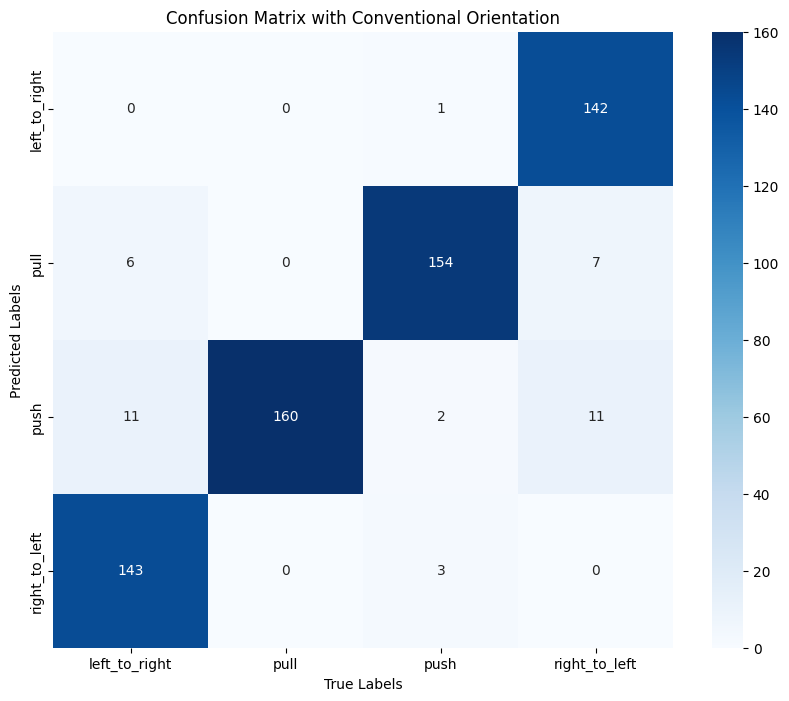

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your confusion matrix data as a 2D array (example data, replace with your actual data)
confusion_matrix_data = np.array([[0, 6, 11, 143],
                                  [0, 0, 160, 0],
                                  [1, 154, 2, 3],
                                  [142, 7, 11, 0]])

# The labels for the classes
labels = ['left_to_right', 'pull', 'push', 'right_to_left']

# Creating a seaborn heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_data.T, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Labels, title and ticks
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Confusion Matrix with Conventional Orientation')
plt.show()